# POKEMON IMAGE DETECTION USING CNN

In [1]:
import os
import pandas as pd
import numpy as np
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
import matplotlib.pyplot as plt
import fnmatch

ModuleNotFoundError: No module named 'torch'

## Exploring DataFrame

In [2]:
import pandas as pd
pokemons = pd.read_csv(r"C:\Users\USER\Downloads\7th Sem\DEEP LEARNING\Project\Dataset\pokemon.csv")

In [3]:
pokemons = pokemons.drop(columns=['Evolution'])

In [4]:
pokemons.shape

(809, 3)

In [5]:
pokemons.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [6]:
pokemons = pokemons.set_index('Name')
pokemons

,Type1,Type2
Name,,
bulbasaur,Grass,Poison
ivysaur,Grass,Poison
venusaur,Grass,Poison
charmander,Fire,NaN
charmeleon,Fire,NaN
...,...,...
stakataka,Rock,Steel
blacephalon,Fire,Ghost
zeraora,Electric,NaN


In [7]:
NUMBER_UNIQUE_TYPES = len(pokemons['Type1'].unique())
NUMBER_UNIQUE_TYPES

18

In [8]:
image_dir = "E:\sugi\sem 7\Deep Learning\Pokemon\images"

In [9]:
pokemons.loc['pichu']['Type1']

'Electric'

In [10]:
poke_types = {
    t:i for i, t in enumerate(pokemons['Type1'].unique())
}
poke_types

{'Grass': 0,
 'Fire': 1,
 'Water': 2,
 'Bug': 3,
 'Normal': 4,
 'Poison': 5,
 'Electric': 6,
 'Ground': 7,
 'Fairy': 8,
 'Fighting': 9,
 'Psychic': 10,
 'Rock': 11,
 'Ghost': 12,
 'Ice': 13,
 'Dragon': 14,
 'Dark': 15,
 'Steel': 16,
 'Flying': 17}

In [11]:
class PokemonDataset(Dataset):
    def __init__(self, image_dir):
        """Initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_path_list = sorted(self._find_files(image_dir))
        
    def __len__(self):
        """Return the size of the dataset."""
        return len(self.image_path_list)

    def __getitem__(self, index):
        image_path = self.image_path_list[index]
        name = image_path.split("/")[-1].replace('.png', '')
        poke_type = pokemons.loc[name]['Type1']
        
        x = io.imread(image_path)
        x = torch.tensor(x).type(torch.FloatTensor)
        x = x[:, :, :3]
        x_min, x_max = torch.min(x), torch.max(x)
        normalized_x = (x - x_min) / (x_max - x_min)
        x = torch.reshape(normalized_x, (3, 120, 120))
        
        return x, poke_types[poke_type]
    
    def _find_files(self, directory, pattern='*.png'):
        """Recursively find all files matching the pattern."""
        image_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                image_path_list.append(os.path.join(root, filename))
        return image_path_list

In [12]:
dataset = PokemonDataset(image_dir=image_dir)
len(dataset)

809

### Data augmentation

In [24]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, GaussianBlur

# Define transformations
transform = transforms.Compose([
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    GaussianBlur(kernel_size=3)
])

# Folder containing images (your original dataset)
image_folder = "E:\sugi\sem 7\Deep Learning\Pokemon\images"  # Replace with the actual folder path

# Load original dataset (list of images)
dataset = []
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for your image types
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path)
        dataset.append(image)

# Create a list to store augmented images
augmented_samples = []

# Number of augmentations per image
num_augmentations = 10

# Apply transformations to each image in the dataset
for image in dataset:
    for _ in range(num_augmentations):
        augmented_image = transform(image)
        augmented_samples.append(augmented_image)

# Combine the original dataset with the augmented samples
combined_dataset = dataset + augmented_samples

# Print the lengths of the original and combined datasets
print(f"Length of original dataset: {len(dataset)}")  # This is the number of original images
print(f"Length of combined dataset: {len(combined_dataset)}")  # This is the number of original + augmented images


Length of original dataset: 809
Length of combined dataset: 8899


### Create training and testing datasets

In [25]:
test_split = .2
shuffle_dataset = True

# dataset_size = len(combined_dataset)
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))

if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(indices)
    
train_indices, test_indices = indices[split:], indices[:split]

In [26]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 5

train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, drop_last=True)

In [36]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, GaussianBlur

# Define transformations, including ToTensor
transform = transforms.Compose([
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    GaussianBlur(kernel_size=3),
    transforms.ToTensor()  # Add ToTensor to convert PIL images to tensors
])

# Custom Dataset class to load images from the folder
class CustomImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]  # Adjust for your image types

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, self.image_filenames[idx]

# Folder containing images
image_folder = "E:\sugi\sem 7\Deep Learning\Pokemon\images" # Replace with actual path

# Create dataset and dataloader
dataset = CustomImageDataset(image_folder, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate through the dataloader
for i, (img, t) in enumerate(train_dataloader):
    print(t)  # `t` will now be the filenames (or labels if you add them), and `img` will be tensors


('bruxish.png', 'wimpod.png', 'lickitung.png', 'skuntank.png', 'morelull.png', 'meditite.png', 'crobat.png', 'meltan.png')
('purrloin.png', 'togepi.png', 'hawlucha.png', 'typhlosion.png', 'phanpy.png', 'heatran.png', 'walrein.png', 'emboar.png')
('nidorina.png', 'mesprit.png', 'rufflet.png', 'nincada.png', 'scatterbug.png', 'beldum.png', 'nidoqueen.png', 'quagsire.png')
('houndour.png', 'drilbur.png', 'wingull.png', 'cranidos.png', 'pikipek.png', 'vigoroth.png', 'kricketune.png', 'sunflora.png')
('prinplup.png', 'petilil.png', 'carbink.png', 'karrablast.png', 'phione.png', 'pancham.png', 'magby.png', 'pidove.png')
('sableye.png', 'metapod.png', 'heatmor.png', 'spoink.png', 'primarina.png', 'cascoon.png', 'relicanth.png', 'bayleef.png')
('dugtrio.png', 'gallade.png', 'forretress.png', 'ampharos.png', 'gengar.png', 'dhelmise.png', 'clauncher.png', 'yanma.png')
('skitty.png', 'kyurem.png', 'tapu-fini.png', 'spinarak.png', 'naganadel.png', 'hippowdon.png', 'garchomp.png', 'dewpider.png')
(

In [37]:
dataloader = DataLoader(combined_dataset, batch_size=5, shuffle=True, drop_last=True) 

In [38]:
len(test_dataloader)

32

## Defining the neural network

In [39]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Max-pooling layers
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(128 * 15 * 15, 256)
        self.fc2 = torch.nn.Linear(256, 18)  # 18 output classes
        
    def forward(self, x):
        # Convolutional layer 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Convolutional layer 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Convolutional layer 3
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 15 * 15)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [40]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device {device}")

model = NeuralNetwork().to(device)
print(model)

Using device cpu
NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=18, bias=True)
)


In [41]:
learning_rate = 1e-3
batch_size = 32
num_epochs = 10

In [42]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # , momentum=0.9

In [43]:
for images, labels in train_dataloader:
    print(labels)

('azelf.png', 'arcanine.png', 'goldeen.png', 'cherrim.png', 'hitmonchan.png', 'combusken.png', 'scizor.png', 'vaporeon.png')
('silvally.png', 'dodrio.png', 'victini.png', 'garchomp.png', 'huntail.png', 'geodude.png', 'seadra.png', 'bagon.png')
('exploud.png', 'morelull.png', 'hoothoot.png', 'heliolisk.png', 'haxorus.png', 'rattata.png', 'nidorina.png', 'gothita.png')
('sealeo.png', 'kyurem.png', 'pheromosa.png', 'ditto.png', 'pyroar.png', 'pangoro.png', 'jumpluff.png', 'pineco.png')
('porygon.png', 'meganium.png', 'carnivine.png', 'komala.png', 'aromatisse.png', 'liepard.png', 'teddiursa.png', 'poliwhirl.png')
('poliwag.png', 'swellow.png', 'swadloon.png', 'ambipom.png', 'murkrow.png', 'eelektross.png', 'wobbuffet.png', 'pumpkaboo-average.png')
('stufful.png', 'ferroseed.png', 'glameow.png', 'excadrill.png', 'lopunny.png', 'charjabug.png', 'slaking.png', 'jolteon.png')
('munna.png', 'shieldon.png', 'shroomish.png', 'dewgong.png', 'unown.png', 'wimpod.png', 'ariados.png', 'suicune.png')

In [44]:
model_device = next(model.parameters()).device
input_device = images.device
print(f"model device: {model_device}")
print(f"input device: {input_device}")

model device: cpu
input device: cpu


In [46]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Define transformations, including ToTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.Resize((120, 120)),  # Ensure images are resized to the correct input size
    transforms.ToTensor()  # Add ToTensor to convert PIL images to tensors
])

# Custom Dataset class to load images from the folder
class CustomImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]  # Adjust for your image types

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB to ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image, self.image_filenames[idx]

# Usage
image_folder = "E:\sugi\sem 7\Deep Learning\Pokemon\images"  # Replace with your image folder path
dataset = CustomImageDataset(image_folder, transform=transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


In [57]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
        
        # Extract class names from folder names (Assuming images are organized in subfolders)
        self.class_names = os.listdir(image_folder)
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.class_names)

        # Create a mapping of image filenames to labels
        self.image_labels = [self.label_encoder.transform([os.path.split(f)[-1].split('_')[0]])[0] for f in self.image_filenames]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.image_labels[idx]

        if self.transform:
            image = self.transform(image)

        # Convert label to LongTensor
        label = torch.tensor(label, dtype=torch.long)  # Ensure label is LongTensor

        return image, label

# Usage
image_folder = "E:\sugi\sem 7\Deep Learning\Pokemon\images"  # Replace with your image folder path
dataset = CustomImageDataset(image_folder, transform=transform)

# Define num_classes
num_classes = len(dataset.label_encoder.classes_)  # This gets the number of unique classes

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model (using ResNet18 as an example)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Use the actual number of classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Start training
train_model(model, train_dataloader, criterion, optimizer, num_epochs=5)


C:\Users\sugirdha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sugirdha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:45<00:00,  2.25it/s]


Epoch [1/5], Loss: 8.6403


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:27<00:00,  3.73it/s]


Epoch [2/5], Loss: 7.6436


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:29<00:00,  3.42it/s]


Epoch [3/5], Loss: 7.2275


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:29<00:00,  3.41it/s]


Epoch [4/5], Loss: 6.9223


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:29<00:00,  3.43it/s]

Epoch [5/5], Loss: 6.7651


torch.Size([1, 3, 120, 120]) tensor(808)


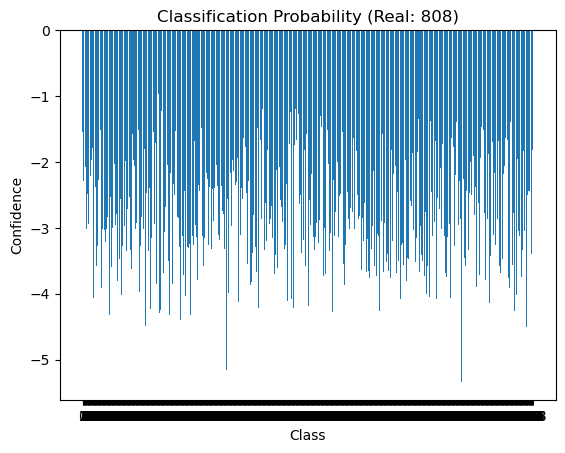

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Get the last image and its label from the dataset
image, label = dataset[-1]
image = image.unsqueeze(0).to(device)  # Add a batch dimension and move to device

print(image.shape, label)

# Make predictions with the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    pred = model(image)

# Convert the Torch tensor to a NumPy array
numpy_array = pred.cpu().detach().numpy()

# Flatten the array (since it has a shape of (1, num_classes), we can flatten it)
flattened_array = numpy_array.flatten()

# Create a bar plot of the flattened array
plt.bar(range(len(flattened_array)), flattened_array)
plt.xlabel('Class')
plt.ylabel('Confidence')
plt.xticks(range(len(flattened_array)))  # Update to reflect the number of classes
plt.title(f'Classification Probability (Real: {label})')
plt.show()


# PREDICTION USING PYTORCH 

In [63]:
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
import pandas as pd
import glob
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn


In [64]:
import glob

# Adjust the path to point to your images folder
images_path = glob.glob(r'E:\sugi\sem 7\Deep Learning\Pokemon\images\*')

# Print the list of image paths
print(images_path)


['E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\abomasnow.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\abra.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\absol.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\accelgor.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\aegislash-blade.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\aerodactyl.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\aggron.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\aipom.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\alakazam.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\alomomola.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\altaria.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\amaura.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\ambipom.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\amoonguss.png', 'E:\\sugi\\sem 7\\Deep Learning\\Pokemon\\images\\ampharos.png', 'E:\\sugi\\sem 7\\Deep Learn

In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load your CSV file
df = pd.read_csv(r'E:\sugi\sem 7\Deep Learning\Pokemon\pokemon.csv')

# Assuming 'Type1' is the column with the class labels
classes = df['Type1'].unique()

# Construct image paths based on the names in your DataFrame
# Adjust this if your image files have a different extension or naming convention
X = r'E:\sugi\sem 7\Deep Learning\Pokemon\images\\' + df['Name'].values + '.png'
y = df['Type1'].values

# Initialize OneHotEncoder
label_encoder = OneHotEncoder(sparse_output=False)

# Transform the labels into one-hot encoded format
y = label_encoder.fit_transform(np.expand_dims(y, 1))

# Optionally, print to check the shapes
print("Shape of X:", len(X))
print("Shape of y:", y.shape)


Shape of X: 809
Shape of y: (809, 18)


In [66]:
print(classes)

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']


In [67]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
import torchvision.transforms as transforms

"""
- RandomHorizontalFlip
- RandomVerticalFlip
- ToTensor
- Normalize (custom normaliser)
"""

image_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize((0.0, 0.0, 0.0), (1.0/255, 1.0/255, 1.0/255)) 
])

In [69]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, images_paths, labels, transform=None):
        # self.images = list(map(lambda x: toImageTensor(x), images_path))
        self.labels = torch.tensor(labels, dtype=torch.float32)
        # self.labels = labels
        self.image_paths = images_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        # Apply transformatiojn
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [70]:
train_dataset = ImageDataset(images_paths=train_X, labels=train_y, transform=image_transform)
test_dataset = ImageDataset(images_paths=test_X, labels=test_y, transform=image_transform)

In [71]:
print("Number of training items:", len(train_y))

Number of training items: 647


In [72]:
from torchvision import utils
def plot_img(img,y=None,color=True):
    npimg = img.numpy()
    npimg_T = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg_T)
    plt.title('Image samples from each of the 10 classes')
    plt.axis('on')

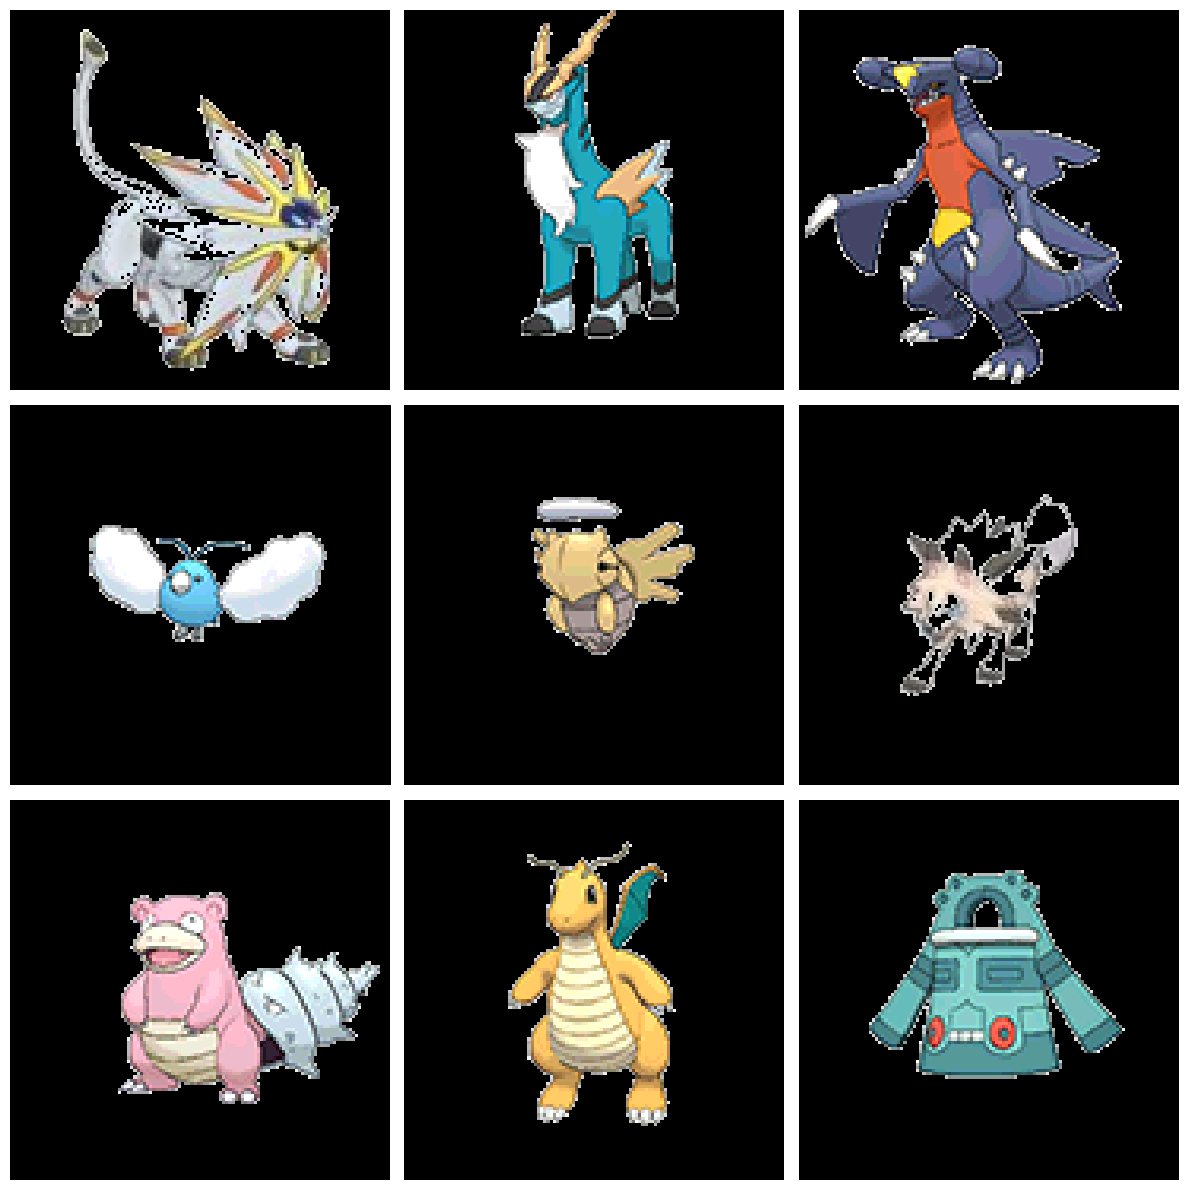

In [74]:
import matplotlib.pyplot as plt

# Function to plot an individual image
def plot_img(img):
    # Normalize the image for display
    img_min, img_max = img.min(), img.max()
    normalized_img = (img - img_min) / (img_max - img_min)
    
    # Change the shape to (H, W, C)
    normalized_img = normalized_img.permute(1, 2, 0)
    
    plt.imshow(normalized_img)
    plt.axis('off')  # Hide axes

# Set the figure size for larger images
plt.figure(figsize=(12, 12))  # Adjust the size as needed

# Loop to display images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = train_dataset[i][0]
    plot_img(img)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [75]:
# Build model

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1,)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 30 * 30, 120)
        self.fc2 = nn.Linear(120, len(classes))

    def forward(self, x):
        # [(W−K+2P)/S]+1
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # Conv to Linear
        x = x.view(-1, 64 * 30 * 30)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        # x = torch.softmax(x, dim=1)
        return x

In [76]:
device = torch.device('cpu')

model = Classifier()

model = model.to(device)

print(model)

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=57600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=18, bias=True)
)


In [77]:
from torch.utils.data import DataLoader
import torch.optim as optim

batch_size = 32
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 10


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    running_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.0898
Epoch [2/10], Loss: 0.0834
Epoch [3/10], Loss: 0.0749
Epoch [4/10], Loss: 0.0634
Epoch [5/10], Loss: 0.0506
Epoch [6/10], Loss: 0.0359
Epoch [7/10], Loss: 0.0238
Epoch [8/10], Loss: 0.0142
Epoch [9/10], Loss: 0.0091
Epoch [10/10], Loss: 0.0058


In [78]:
from sklearn.metrics import accuracy_score
# Evaluation
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # _, predicted = torch.max(outputs, 2)
        max_index = np.argmax(outputs, axis=1)

        one_hot = np.zeros_like(outputs)
        one_hot[np.arange(len(outputs)), max_index] = 1
        
        total += labels.size(0)
        c = (torch.tensor(one_hot) == labels).sum().item() / 18
        correct += c


print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


In [79]:
decoder = label_encoder.inverse_transform

i = 20

p = model(train_dataset[i][0]).detach().numpy()

max_index = np.argmax(p)

one_hot = np.zeros_like(p)
one_hot[np.arange(len(p)), max_index] = 1


print(f'Predicted: {decoder(one_hot)}')
print(f'Original : {decoder([np.array(train_dataset[i][1])])}')
# decoder([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


Predicted: [['Dragon']]
Original : [['Dragon']]


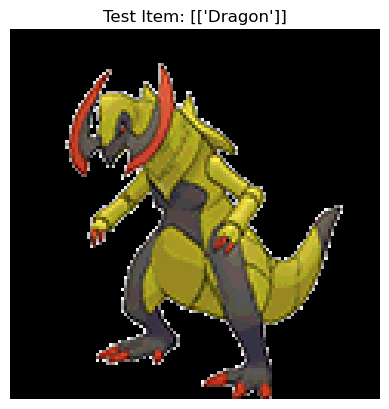

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Assuming 'train_dataset' contains image tensors directly
decoder = label_encoder.inverse_transform

# Set the index of the image you want to test
i = 20


# Retrieve the image tensor and label from the training dataset
image_tensor = train_dataset[i][0]  # This should be a tensor
original_label = train_dataset[i][1]  # This should give you the original label

# Ensure that the image tensor is a 3D tensor (C, H, W)
if isinstance(image_tensor, torch.Tensor):
    # Convert the tensor to a numpy array for displaying
    image_np = image_tensor.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    image_np = (image_np * 255).astype(np.uint8)  # Scale to 0-255 for display if necessary
else:
    print("Image tensor is not a valid tensor.")

# Display the original image
plt.imshow(image_np)
plt.title(f"Test Item: {decoder([np.array(original_label)])}")
plt.axis('off')  # Hide axes
plt.show()